# Neutral Theory 

## 0. Data acqusition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate as I
%matplotlib inline


In [2]:
data = pd.read_csv("bci05.csv")
data.describe()

,tag,gx,gy,dbh,pom,date
count,368122.000000,368035.000000,368035.000000,208387.000000,368122.000000,368070.000000
mean,262011.545901,494.356946,254.214007,49.337660,0.696302,8912.050490
std,201947.633329,291.017349,144.039966,83.399585,0.653746,77.962794
min,-42299.000000,0.000000,0.000000,10.000000,0.000000,8768.000000
25%,107171.250000,237.800000,130.300000,16.000000,0.000000,8841.000000
50%,210413.500000,492.200000,254.700000,25.000000,1.000000,8915.000000
75%,409068.750000,747.700000,380.100000,47.000000,1.000000,8975.000000
max,749571.000000,999.900000,499.900000,2765.000000,5.000000,9154.000000


In [3]:
data = data[data["status"]=='A'][["tag", "sp", "gx", "gy"]]

In [4]:
# 1) Species spotting
types = data['sp'].value_counts().keys() 
S = len(types)
print("There are {} different species".format(S))

There are 299 different species


## 1. Relative species abundances (RSA)

In order to make $800$ subplots we divided the dataset in cells of $25 \times 25$. Then we computed the abundance of each species for each subplot. Finally we built an array `X` containing all the nonzero abundances.

In [5]:
# 25 * 25 
data["i"], data["j"] = data["gx"]//25, data["gy"]//25
# a)
cell_pop = data.groupby(["i", "j"])["sp"].value_counts()
# b) shaping them in a matrix
cell_pop_M = cell_pop.unstack().stack(dropna = False).fillna(0).astype(int)
cell_pop_M = np.array(cell_pop_M).reshape(40, 20, 299) # (i, j, specie)


In [6]:
# Flatten all and remove zero values
flatten_pop = cell_pop_M.flatten() 
X = flatten_pop[np.nonzero(flatten_pop)]

In [7]:
X.shape

(49479,)

## 2. Experimental cumulative distribution of the abundances

In this section we construct the probability distribution $P_>(n)$ that a species have $n$ or more individuals. 

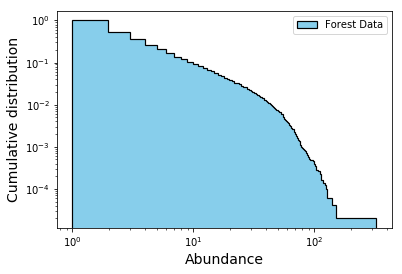

In [74]:
_ = plt.hist(X, bins=X.max(), cumulative=-1, density=True, edgecolor='black', 
             linewidth = 1.2, fill=True, facecolor='skyblue', histtype="step", label="Forest Data")
plt.yscale("log") 
plt.xscale("log")

plt.xlabel("Abundance", fontsize=14)
plt.ylabel("Cumulative distribution", fontsize=14)
plt.legend()

plt.show()

## 3. Theoretical estimate of the cumulative distribution

Probability mass function normalized with $\sum_{n=0}^\infty P(n) = 1$:

$P^{(0)}(n) = -\frac{(1-\nu)^n}{n log(\nu)}$

Probability mass function normalized with $\sum_{n=1}^\infty P(n) = 1$:

$P^{(1)}(n) = \frac{(1-\nu)^n}{n \Gamma(0,-log(1-\nu))}$

where we use the incomplete $\Gamma$ function:

$\Gamma(a,x) \equiv \int_x^\infty dt~t^{a-1}e^{-t}$

In our specific case it yields:

$\Gamma(0,-log(1-\nu)) = \int_{-log(1-\nu))}^\infty dt~\frac{e^{-t}}{t} = \int_1^\infty dn~\frac{(1-\nu)^n}{n} $

To use the gamma function with $a=0$ in python we choose `exp1` from `scipy`. Check the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.exp1.html).

In [9]:
from scipy.special import exp1

In [10]:
def p0(n, nu=0.05):
    if n == 0:
        return 0
    return -((1-nu)**n/np.log(nu))/n

def p1(n, nu=0.05):
    return (1-nu)**(n-1)/(n*exp1(-np.log(1-nu)))

def integrate_p(func, n):
    return I.quad(func, n, np.inf)[0]

#cumulative_p0 = []
cumulative_p1 = []

for n in range(1, 140):
    #cumulative_p0.append(integrate_p(p, n))
    cumulative_p1.append(integrate_p(p1, n))


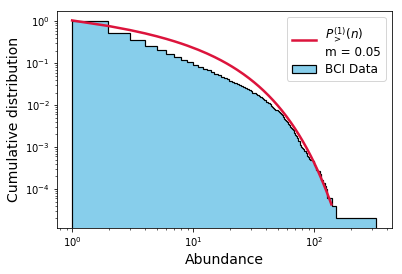

In [92]:
x = np.arange(1, 140)
_ = plt.hist(X, bins=X.max(), cumulative=-1, density=True, edgecolor='black', 
             linewidth = 1.2, fill=True, facecolor='skyblue', histtype="step", label="BCI Data")
#plt.plot(x, cumulative_p0, label="p1")
plt.plot(x, cumulative_p1, label=r"$P_>^{(1)}(n)$"+"\nm = 0.05", color = "crimson", linewidth = 2.5)

plt.yscale("log")
plt.xscale("log")

plt.xlabel("Abundance", fontsize=14)
plt.ylabel("Cumulative distribution", fontsize=14)
plt.legend(fontsize = 12)

plt.show()
plt.close()

## 4. Species Area Relationship (SAR)

We now calculate the mean number of species for increasing area. i.e.  $\langle S(j \frac{a}{A}) \rangle$

In [12]:
presences = cell_pop_M.reshape((800,-1))
# h4k1ng
presences = presences.astype(np.bool).astype(np.int)

In [50]:
S_means = []

# h4k1ng^2
Presences = np.concatenate((presences, presences))
for j in range(1, 801):
    S = []
    for i in range(800//j):
        index = np.random.randint(800)
        s = Presences[index:index+j].sum(axis=0).astype(np.bool).astype(np.int)
        S.append(s.sum())
    S_means.append(np.array(S).mean())

The fitted m parameter result is:  [9.76866684e-05]


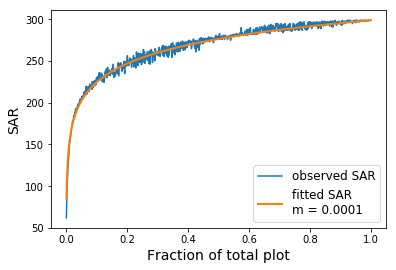

In [86]:
S_tot = 299
N = 800

def theoretical_curve(j, m, S=299, N=800):
    return S*(1-(np.log(j*(1-m)/N+m))/np.log(m))

from scipy.optimize import curve_fit
x = np.arange(1,801)
m, m_err = curve_fit(lambda j,m : theoretical_curve(j, m, S_tot, N), x, S_means, bounds=(1e-8, 1))

plt.plot(x/N, S_means, label="observed SAR")
plt.plot(x/N, theoretical_curve(x, m), label="fitted SAR \nm = %.4f"%m , linewidth = 2)
print("The fitted m parameter result is: ", m)

plt.xlabel("Fraction of total plot", fontsize=14)
plt.ylabel("SAR", fontsize=14)
plt.legend(fontsize = 12)

plt.show()
plt.close()

## 5. Logistic growth

New rates for the logistic growth model:

$b(n) = b n$

$d(n) = b n \frac{n}{K}$

with $b(0) = \nu$ and $d(0) = 0$.

We get:

$P(n) = \frac{K^n}{n!}\frac{mP_0}{b n}$

Normalizing with the condition $\sum_{n=1}^{\infty}P(n) = 1$ we can obtain an expression for $P_0$:

$$P_0 = \frac{b}{m} \left(\sum_{n=1}^{\infty} \frac{K^n}{n~n!}\right)^{-1}$$

In [88]:
# Parameters of the model (arbitrary)
b = 1 # intrinsic growth
m = 0.1 # migration factor
k = 10 # carrying capacity

In [89]:
import mpmath as mp

summ = mp.nsum(lambda n: k**n/(n*mp.fac(n)), [1, mp.inf])

P0 = float(b/m*(summ)**-1)
#P0 = float(b*(summ+b/m)**-1/m)

def pn(n):
    from scipy.special import factorial
    c1 = m*P0*k**n
    c2 = n*b*factorial(n)
    return c1/c2

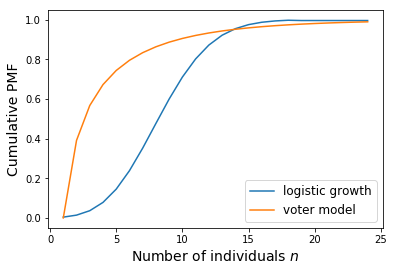

In [91]:
xx = np.arange(1,25)

ps = [p0(x-1, nu=0.1) for x in xx]
ps = np.cumsum(ps)
    
plt.plot(xx, np.cumsum(pn(xx)), label = "logistic growth")
plt.plot(xx, ps, label = "voter model")

plt.xlabel("Number of individuals $n$", fontsize=14)
plt.ylabel("Cumulative PMF", fontsize=14)

plt.legend(fontsize = 12)
plt.show()